### Imports

In [1]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Model.DataLoader import DataLoaderManager
from Model.Train import Trainer
from Model.Loss import Loss
from Model.Test import Tester

## Constants

In [2]:
epochs = 1
image_size = 224
num_classes = 1
learning_rate = 1e-4
train_size = 0.7
test_size = 0.15
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data loading

Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-1.) tensor(1.) tensor(0.) tensor(1.)


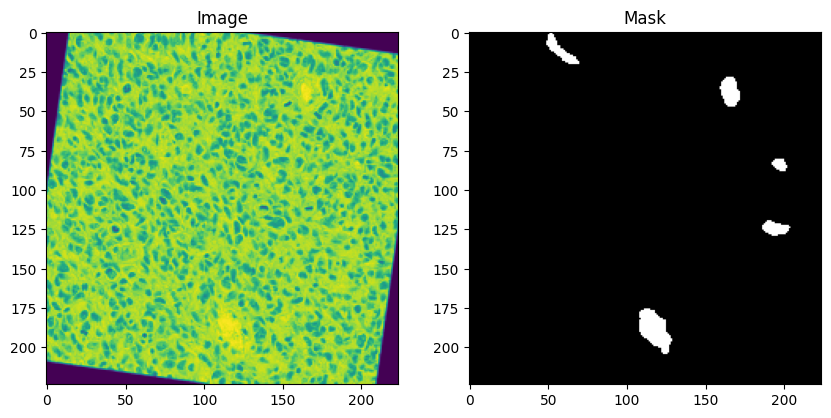

Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-1.) tensor(1.) tensor(0.) tensor(1.)


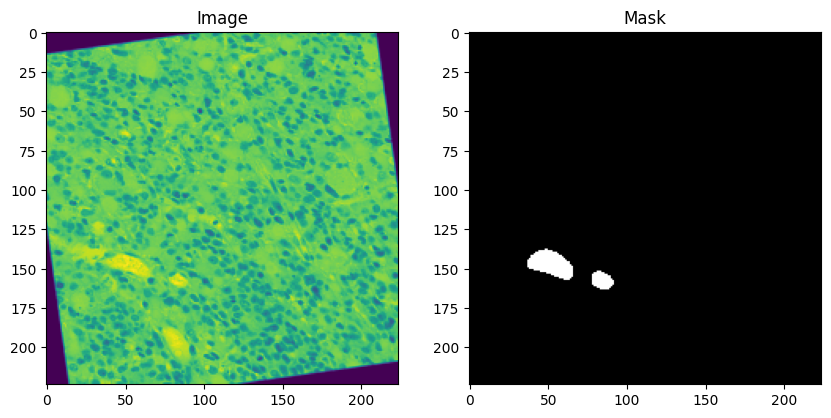

Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-1.) tensor(1.) tensor(0.) tensor(1.)


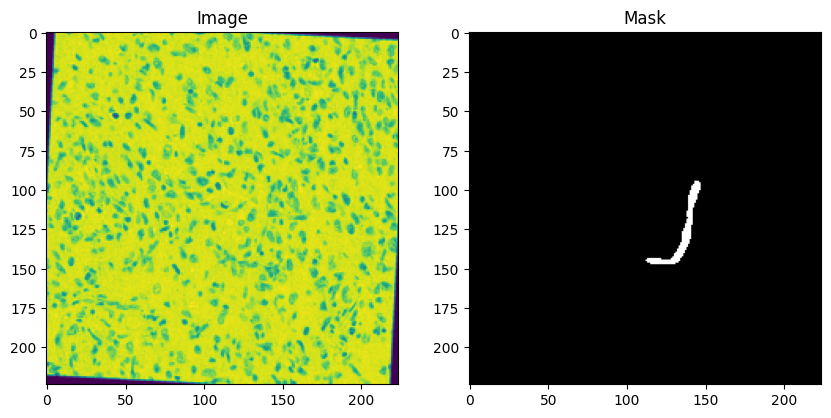

Train size : 30
Validation size : 7
Test size : 7


In [3]:
dataset = DataLoaderManager(root_dir="../patches",kidney_dir=False, data_augmentation=True, shape=(image_size,image_size))

train_size = int(train_size * len(dataset))
test_size =  int(test_size * len(dataset))
val_size = len(dataset) - train_size - test_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

dataset.show_data(train_loader)
dataset.show_data(val_loader)
dataset.show_data(test_loader) 

print(f"Train size : {len(train_loader)}")
print(f"Validation size : {len(val_loader)}")
print(f"Test size : {len(test_loader)}")

## Model Training
- Encoder can be one of : 
    - 'vgg16', 'vgg19', 
    - 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
    - 'efficientnet-b3'


In [4]:
encoder_name = 'efficientnet-b3'
model = smp.Unet(encoder_name=encoder_name, encoder_weights='imagenet', classes=num_classes, in_channels=3)
model = model.to(device)
optimizer = torch.optim.AdamW
loss = Loss.combined_loss
trainer = Trainer()
pos_weight = trainer.calculate_weights(train_loader)
print(f"Positive weights : {pos_weight}")
history = trainer.set_model(model)\
    .set_loader(train_loader, val_loader, test_loader)\
    .set_loss_fn(loss)\
    .set_optimizer(optimizer)\
    .fit(learning_rate, epochs, 1/pos_weight)

Positive weights : 70.89596782187884
Training the model on cuda...
Validating...
Epoch [1/1], Training Loss: 0.9679473320643107, Validation Loss: 0.905098923615047
Training complete.


## Model saving 
- Path explanation : 
    - [MODEL NAME]\_[MODEL VERSION]\_[LOSS]\_[OPTIMIZER]\_[WEIGHTED CLASS]\_[AUGMENTED DATA]\_[IMAGE_CHANNELS]\_[NUMBER CLUSTERS]\_[NUMBER EPOCHS]

In [5]:
suffix = "local_model_EN_b3_BD_adamW_weight_augmented_3D_3C_100epochs"

model_path = f"../params/model_params/{suffix}"
history_path = f"../params/model_metrics/{suffix}"

trainer.save(model_path, history_path)

Saving the model...
Model saved.


## Plotting results

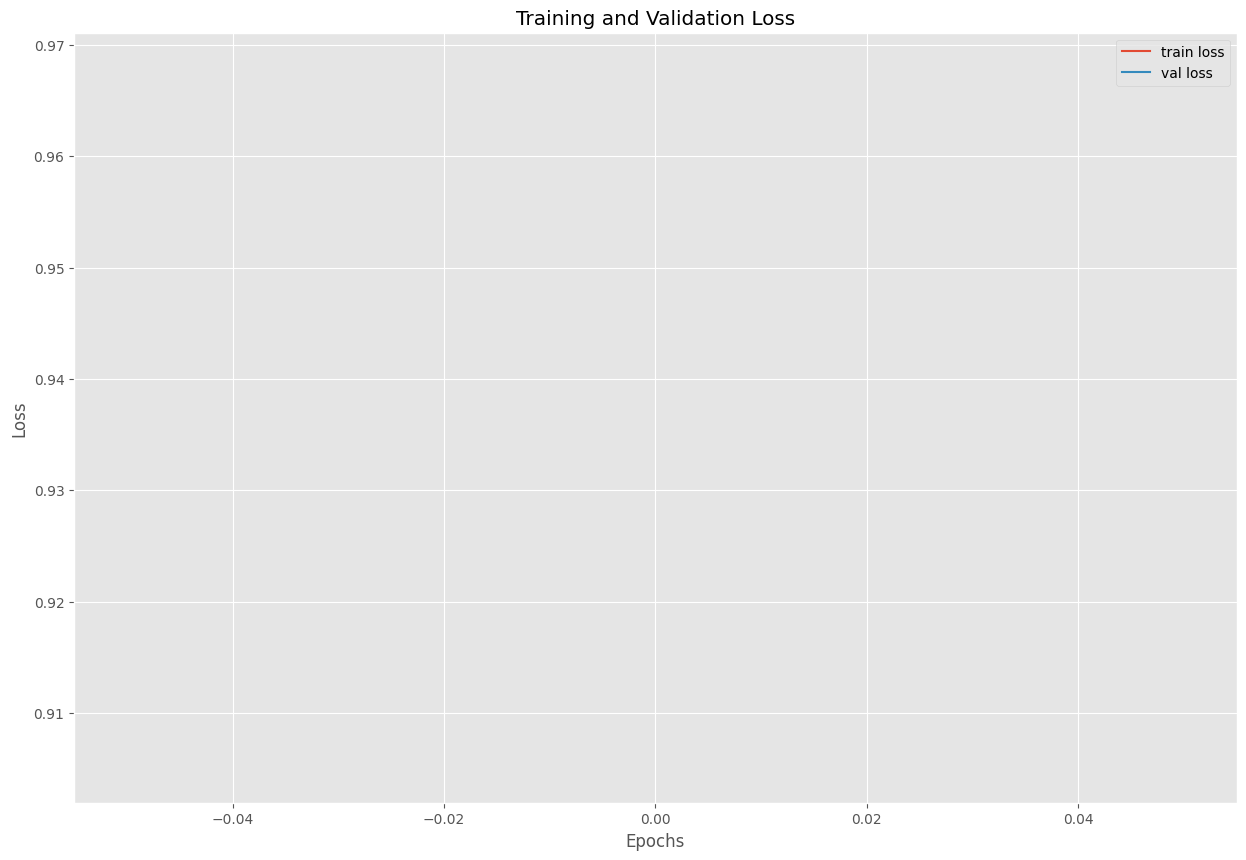

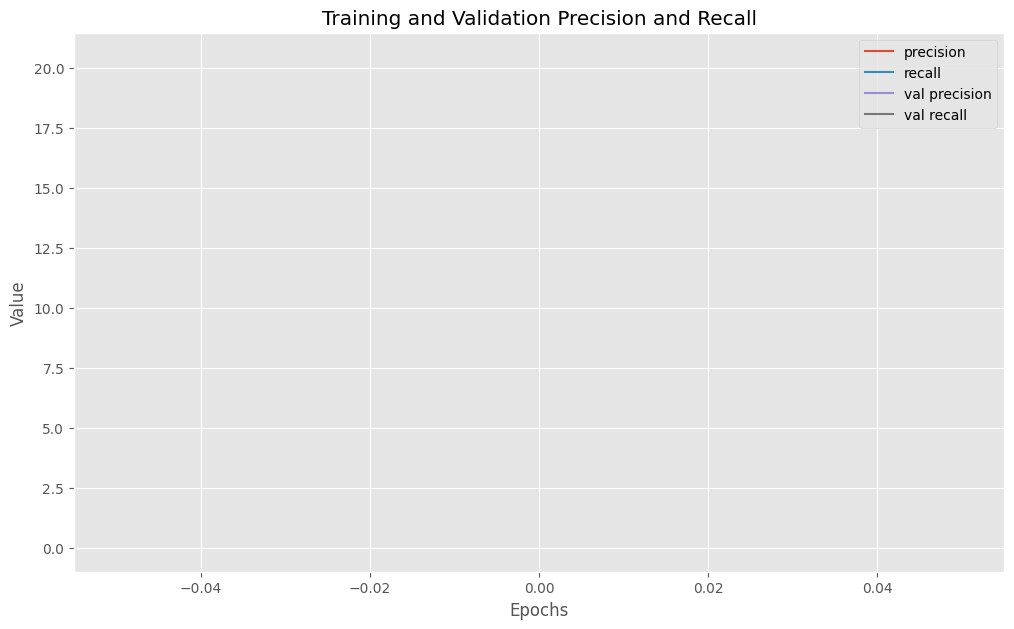

Testing the model
Accuracy: 0.9316699335984394, Precision: 0.03793970069960285, Recall: 0.1529330354502248, F1 Score: 0.06079688182924935


(0.9316699335984394,
 0.03793970069960285,
 0.1529330354502248,
 0.06079688182924935)

In [6]:
train_loss = history['training']['loss']
val_loss = history['validation']['loss']
precision = history['training']['precision']
recall = history['training']['recall']
val_p = history['validation']['precision']
val_r = history['validation']['recall']

trainer.plot_loss(train_loss, val_loss)
trainer.plot_precision_recall(precision, recall, val_p, val_r)
trainer.evaluate()

## Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


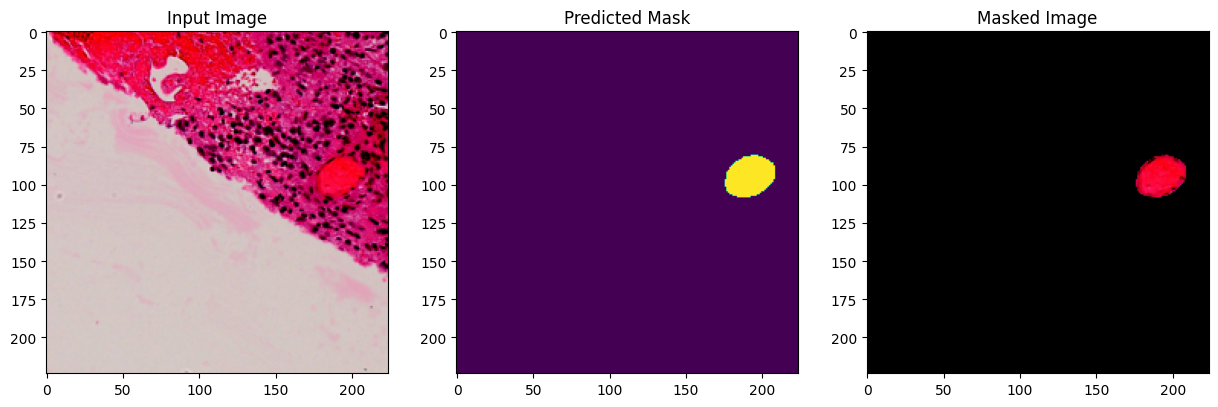

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


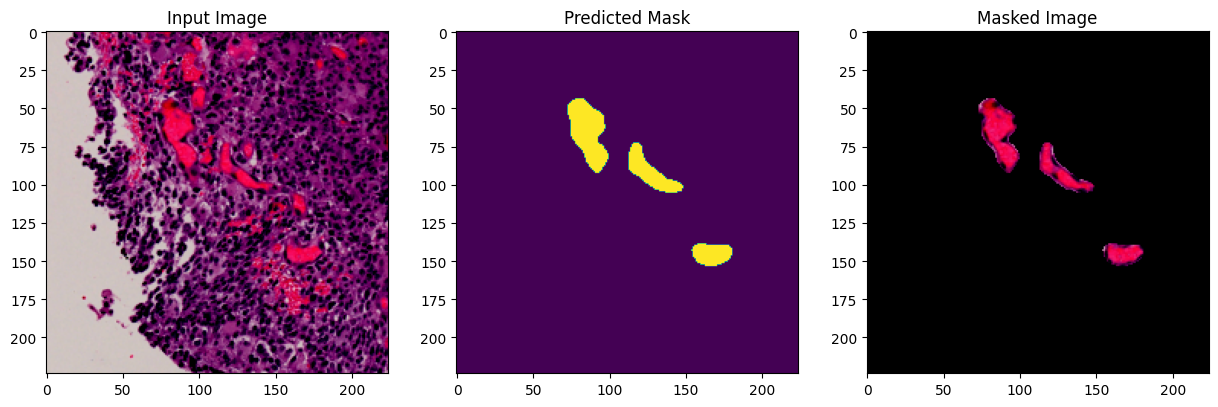

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


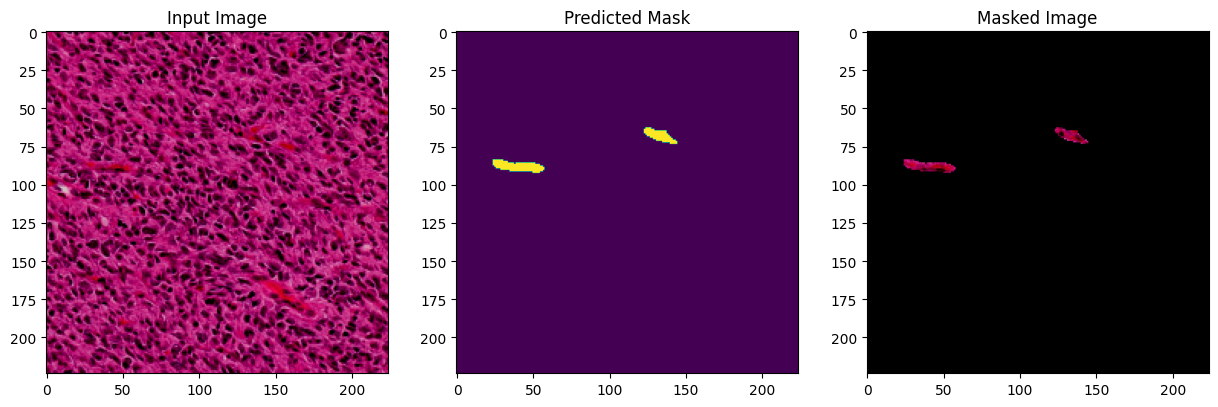

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


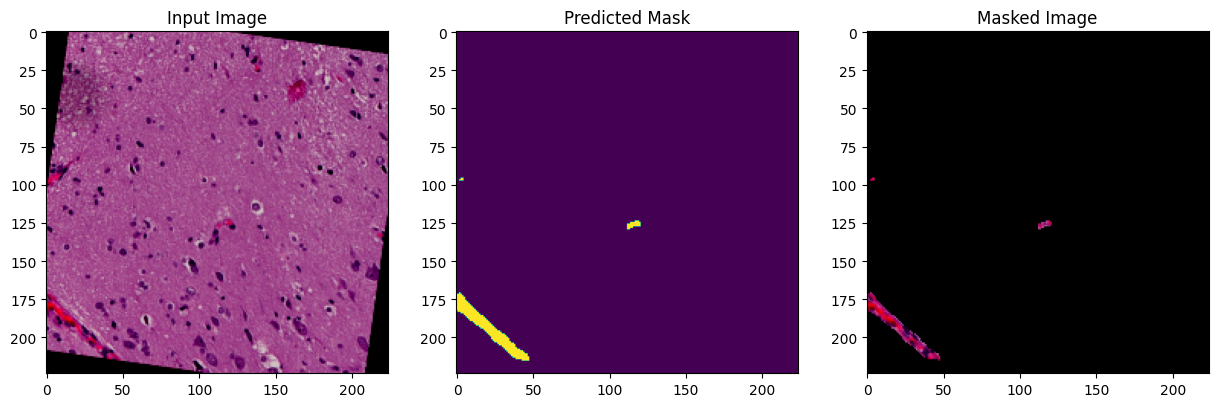

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


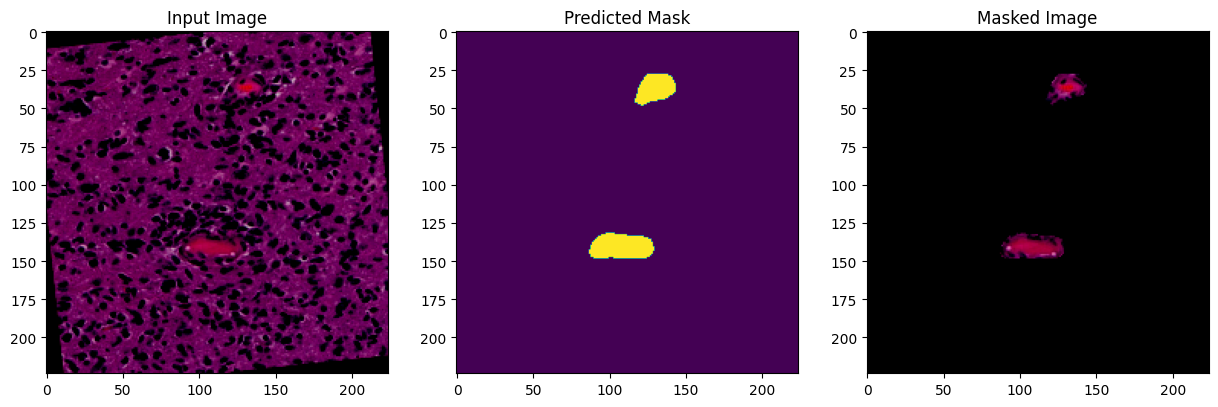

In [4]:
tester = Tester(state="../params/model_params/local_model_EN_b3_BD_adamW_weight_augmented_3D_3C_100epochs")
tester.predict_loader(test_loader)